# Crazy Fast Baseline using Torch XLA by [@shonenkov](https://www.kaggle.com/shonenkov)


Hi everyone!

Thank you all, my friends, for reading my kernels about this competition:

- [[Merge External Data]](https://www.kaggle.com/shonenkov/merge-external-data)
- [[Training CV] Melanoma Starter](https://www.kaggle.com/shonenkov/training-cv-melanoma-starter)
- [[Inference Single Model] Melanoma Starter](https://www.kaggle.com/shonenkov/inference-single-model-melanoma-starter)

Now I would like to share with you Torch XLA baseline with crazy fast learning using TPU ;)
Don't afraid! If you understand [[Training CV] Melanoma Starter](https://www.kaggle.com/shonenkov/training-cv-melanoma-starter), then TPU and this kernel are super easy for understanding !

# Main Idea

[PyTorch XLA](https://github.com/pytorch/xla) is enabling PyTorch on Google TPU. So lets do it for Melanoma Competition! At the end of this kernel you will find link on Google Colab with prepared baseline!

# Dependencies

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev > /dev/null
!pip install catalyst > /dev/null
!pip install --no-deps albumentations --force-reinstall > /dev/null
!pip install -q efficientnet_pytorch > /dev/null
!pip install --no-deps timm > /dev/null
!git clone https://github.com/4uiiurz1/pytorch-auto-augment > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  56853      0 --:--:-- --:--:-- --:--:-- 56853
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/89.7 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/117.1 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/1.7 MiB.                                      
ERROR: fastai 1.0.61 requires torchvision, which is not installed.
ERROR: kornia 0.3.1 has requirement torch==1.5.0, but you'll have torch 1.6.0a0+af05158 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is i

In [2]:
import os
os.environ['XLA_USE_BF16'] = "1"

import pandas as pd
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import albumentations as A
import torch
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn import functional as F
from glob import glob
import sklearn
from torch import nn
import warnings

warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
ROOT_PATH = './'
DATA_PATH = f'../input/melanoma-merged-external-data-512x512-jpeg'

In [4]:
df_folds = pd.read_csv(f'{DATA_PATH}/folds_08062020.csv', index_col='image_id')

# [PyTorch Auto Augment](https://github.com/4uiiurz1/pytorch-auto-augment)

In [5]:
from albumentations.pytorch import ToTensor
from torchvision import transforms

import sys
sys.path.insert(0, './pytorch-auto-augment')
from auto_augment import AutoAugment, Cutout


def get_train_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AutoAugment(),
        Cutout(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

def get_valid_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

In [6]:
TRAIN_ROOT_PATH = f'{DATA_PATH}/512x512-dataset-melanoma/512x512-dataset-melanoma'

def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, labels, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.resize(image, (256, 256), cv2.INTER_AREA)
        label = self.labels[index]
        target = onehot(2, label)        
        if self.transforms:
            image = self.transforms(image)
        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def get_labels(self):
        return list(self.labels)

In [7]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    labels=df_folds[df_folds['fold'] != fold_number].target.values,
    transforms=get_train_transforms(),
)

df_val = df_folds[(df_folds['fold'] == fold_number) & (df_folds['source'] == 'ISIC20')]

validation_dataset = DatasetRetriever(
    image_ids=df_val.index.values,
    labels=df_val.target.values,
    transforms=get_valid_transforms(),
)

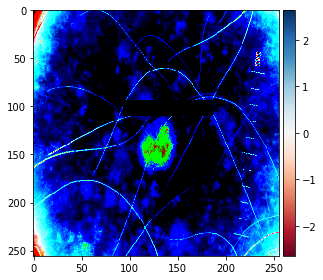

In [8]:
from skimage import io

image, target = train_dataset[777]
numpy_image = image.permute(1,2,0).cpu().numpy()

io.imshow(numpy_image);

# Metrics

In [9]:
from sklearn import metrics

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,1]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = sklearn.metrics.roc_auc_score(self.y_true, self.y_pred)

    @property
    def avg(self):
        return self.score

class APScoreMeter(RocAucMeter):
    def __init__(self):
        super(APScoreMeter, self).__init__()

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,1]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = sklearn.metrics.average_precision_score(self.y_true, self.y_pred)

# Losses

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)

            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss

            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

# TPU Fitter

In [11]:
import warnings

warnings.filterwarnings("ignore")

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler


class TPUFitter:
    
    def __init__(self, model, device, config, sub_folder):

        self.config = config
        self.epoch = 0
        self.best_score = 0
        self.base_dir = f'./{config.folder}/{sub_folder}'
        time.sleep(1)
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config.lr*xm.xrt_world_size())
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)

        self.criterion = FocalLoss(logits=True).to(self.device)
        # self.criterion = LabelSmoothing().to(self.device)
        xm.master_print(f'Fitter prepared. Device is {self.device}')

        self.best_loss = 10**5

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            para_loader = pl.ParallelLoader(train_loader, [self.device])
            summary_loss, roc_auc_scores, ap_scores = self.train_one_epoch(para_loader.per_device_loader(self.device))
            
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, roc_auc: {roc_auc_scores.avg:.5f}, ap: {ap_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            t = time.time()
            para_loader = pl.ParallelLoader(validation_loader, [self.device])
            summary_loss, roc_auc_scores, ap_scores = self.validation(para_loader.per_device_loader(self.device))
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, roc_auc: {roc_auc_scores.avg:.5f}, ap: {ap_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=roc_auc_scores.avg)

            if e > 20: # hardcode for keep memory
                self.save(f'{self.base_dir}/checkpoint-{str(self.epoch).zfill(3)}epoch.bin')

            self.epoch += 1
    
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        roc_auc_scores = RocAucMeter()
        ap_scores = APScoreMeter()

        t = time.time()
        for step, (images, targets) in enumerate(val_loader):
            with torch.no_grad():
                targets = targets.to(self.device, dtype=torch.float32)
                batch_size = images.shape[0]
                images = images.to(self.device, dtype=torch.float32)
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                roc_auc_scores.update(targets, outputs)
                ap_scores.update(targets, outputs)
                summary_loss.update(loss.detach().item(), batch_size)
                
        return summary_loss, roc_auc_scores, ap_scores
         
    def train_one_epoch(self, train_loader):
        self.model.train()

        summary_loss = AverageMeter()
        roc_auc_scores = RocAucMeter()
        ap_scores = APScoreMeter()
        t = time.time()
        for step, (images, targets) in enumerate(train_loader):
            images = images.to(self.device, dtype=torch.float32)
            targets = targets.to(self.device, dtype=torch.float32)

            self.optimizer.zero_grad()

            outputs = self.model(images)
            loss = self.criterion(outputs, targets)

            batch_size = images.size(0)

            loss.backward()

            roc_auc_scores.update(targets, outputs)
            ap_scores.update(targets, outputs)
            summary_loss.update(loss.detach().item(), batch_size)

            xm.optimizer_step(self.optimizer)

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss, roc_auc_scores, ap_scores

    def save(self, path):
        self.model.eval()        
        xm.save(self.model.state_dict(), path)

    def log(self, message):
        if self.config.verbose:
            xm.master_print(message)
        with open(self.log_path, 'a+') as logger:
            xm.master_print(f'{message}\n', logger)

In [12]:
class TrainGlobalConfig:
    num_workers = 0 # 4
    batch_size = 16 
    n_epochs = 1 # 40
    lr = 0.000006

    # -------------------
    folder = 'resnext50d_32x4d-autoaugment-KFOLD' 
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='max',
        factor=0.8,
        patience=2,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

# Class Balance "on fly" with XLA

Recently I have created kernel about it in another competition with demonstration how it works! Welcome for reading :)

- [Class Balance with PyTorch/XLA](https://www.kaggle.com/shonenkov/class-balance-with-pytorch-xla)

In [13]:
def _mp_fn(rank, flags):
    xm.set_rng_state(SEED)
    device = xm.xla_device()
    net.to(device)

    train_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    validation_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )

    fitter = TPUFitter(model=net, device=device, config=TrainGlobalConfig, sub_folder=sub_folder)
    if rank == 0:
        time.sleep(1)
    fitter.fit(train_loader, validation_loader)

In [14]:
import timm

def get_net():
    net = timm.create_model('resnext50d_32x4d', pretrained=True)
    net.fc = nn.Linear(in_features=net.fc.in_features, out_features=2, bias=True)
    return net

In [15]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)


for fold_number in range(1): # range(5)
    sub_folder = f'fold{fold_number}'
    net = get_net()

    train_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
        labels=df_folds[df_folds['fold'] != fold_number].target.values,
        transforms=get_train_transforms(),
    )

    df_val = df_folds[(df_folds['fold'] == fold_number) & (df_folds['source'] == 'ISIC20')]
    validation_dataset = DatasetRetriever(
        image_ids=df_val.index.values,
        labels=df_val.target.values,
        transforms=get_valid_transforms(),
    )

    FLAGS={}
    xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50d_32x4d-103e99f8.pth" to /root/.cache/torch/hub/checkpoints/resnext50d_32x4d-103e99f8.pth


Fitter prepared. Device is xla:1

2020-06-09T14:39:56.651438
LR: 4.8e-05
[RESULT]: Train. Epoch: 0, summary_loss: 0.09682, roc_auc: 0.82432, ap: 0.78190, time: 162.30242
[RESULT]: Val. Epoch: 0, summary_loss: 0.00826, roc_auc: 0.82883, ap: 0.11830, time: 83.04015


# Here not enough CPU and RAM for really crazy fast! 

So I prepared Google Colab pipeline for you, my friends! Using PyTorch XLA you can increase speed of research in ~5-10 times! More experiments --> higher LB positions!
I am using Colab Pro with TPU Runtime Type and HIGH-RAM mode ~36GB and 40 CPU. For this model `resnext50d_32x4d` 1 epoch has time: ~60s (train), ~35s (validation).

You should save copy on your drive and run research right now!
- [Prepared Baseline on Colab!](https://drive.google.com/drive/folders/1VerwMHYuP6lrL-CPWJ1_aKYj5Fq2SNsX?usp=sharing)

I have run one experiment for example. Inference you can find here:

- [[Inference] Melanoma Crazy Fast](https://www.kaggle.com/shonenkov/inference-melanoma-crazy-fast)

# Thank you for reading my kernels!